In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

In [51]:
df = pd.read_csv('scada.csv')

In [53]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M', errors='coerce')
df.set_index('Date/Time', inplace=True)
df = df.sort_index()
df.dropna(inplace=True)


In [55]:
# Feature Engineering
df['Wind Speed Rolling_3'] = df['Wind Speed (m/s)'].rolling(window=3).mean()
df['Theoretical vs Active'] = df['Theoretical_Power_Curve (KWh)'] - df['LV ActivePower (kW)']
df.dropna(inplace=True)  # Eliminar filas con NaN generadas por rolling


In [57]:
features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)',
            'Wind Speed Rolling_3', 'Theoretical vs Active']
target = 'LV ActivePower (kW)'



In [59]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [61]:
scaled_features = scaler_x.fit_transform(df[features])
scaled_target = scaler_y.fit_transform(df[[target]])

X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

In [63]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
results = []

for train_index, val_index in kf.split(scaled_features):
    X_train, X_val = scaled_features[train_index], scaled_features[val_index]
    y_train, y_val = scaled_target[train_index], scaled_target[val_index]


In [65]:
model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])

In [67]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])


In [69]:
start_time = time.time()

In [71]:

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - loss: 0.0437 - mae: 0.1352 - val_loss: 0.0016 - val_mae: 0.0293
Epoch 2/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - loss: 0.0092 - mae: 0.0636 - val_loss: 0.0013 - val_mae: 0.0277
Epoch 3/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - loss: 0.0062 - mae: 0.0522 - val_loss: 7.1212e-04 - val_mae: 0.0205
Epoch 4/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - loss: 0.0052 - mae: 0.0476 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 5/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - loss: 0.0047 - mae: 0.0454 - val_loss: 4.2928e-04 - val_mae: 0.0152
Epoch 6/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 0.0041 - mae: 0.0428 - val_loss: 4.1556e-04 - val_mae: 0.0148
Epoch 7/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.0037 - mae: 0.0414 - val_loss: 3.0670e-04 - val_mae: 0.0125
Epoch 8/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - loss: 0.0034 - mae: 0.0397 - val_loss: 3.1200e-04 - val_mae: 0.0127
Epoc

In [73]:
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 38.88 seconds


In [75]:
y_pred = model.predict(X_test)


316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


In [77]:
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"ANN SCADA-only - MSE: {mse}, MAE: {mae}, R^2: {r2}")

ANN SCADA-only - MSE: 971.1329112283147, MAE: 23.267810755375123, R^2: 0.999433350973947


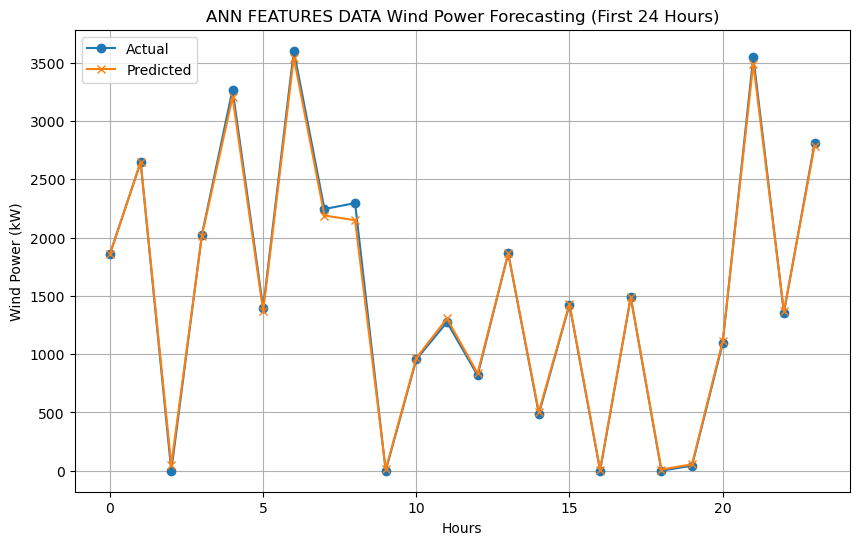

In [79]:
import matplotlib.pyplot as plt
hours = range(24)  # Horas en el eje X
plt.figure(figsize=(10, 6))
plt.plot(hours, y_test_rescaled[:24].flatten(), label='Actual', marker='o')
plt.plot(hours, y_pred_rescaled[:24].flatten(), label='Predicted', marker='x')
plt.title('ANN FEATURES DATA Wind Power Forecasting (First 24 Hours)')
plt.xlabel('Hours')
plt.ylabel('Wind Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
training_loss = history.history['loss'][-1]
validation_loss = history.history['val_loss'][-1]

print(f"Training Loss: {training_loss}")
print(f"Validation Loss: {validation_loss}")

Training Loss: 0.0020442816894501448
Validation Loss: 9.022925223689526e-05


In [83]:
train_df = pd.DataFrame(X_train, columns=features)
test_df = pd.DataFrame(X_test, columns=features)

print("Training Data Stats:")
print(train_df.describe())

print("\nValidation Data Stats:")
print(test_df.describe())

Training Data Stats:
       Wind Speed (m/s)  Wind Direction (°)  Theoretical_Power_Curve (KWh)  \
count      40423.000000        40423.000000                   40423.000000   
mean           0.300348            0.343243                       0.415693   
std            0.167705            0.259503                       0.380206   
min            0.000000            0.000000                       0.000000   
25%            0.167057            0.136889                       0.045326   
50%            0.282445            0.204581                       0.297392   
75%            0.409861            0.559971                       0.828137   
max            1.000000            1.000000                       1.000000   

       Wind Speed Rolling_3  Theoretical vs Active  
count          40423.000000           40423.000000  
mean               0.304499               0.186652  
std                0.174547               0.101694  
min                0.000000               0.000000  
25%        

In [85]:
train_df = pd.DataFrame(X_train, columns=features)
test_df = pd.DataFrame(X_test, columns=features)

print("Training Data Stats")
print(train_df.describe())

print("Validation Data Stats")
print(test_df.describe())

Training Data Stats
       Wind Speed (m/s)  Wind Direction (°)  Theoretical_Power_Curve (KWh)  \
count      40423.000000        40423.000000                   40423.000000   
mean           0.300348            0.343243                       0.415693   
std            0.167705            0.259503                       0.380206   
min            0.000000            0.000000                       0.000000   
25%            0.167057            0.136889                       0.045326   
50%            0.282445            0.204581                       0.297392   
75%            0.409861            0.559971                       0.828137   
max            1.000000            1.000000                       1.000000   

       Wind Speed Rolling_3  Theoretical vs Active  
count          40423.000000           40423.000000  
mean               0.304499               0.186652  
std                0.174547               0.101694  
min                0.000000               0.000000  
25%         

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_ann = model.predict(X_test)

y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled_ann = scaler_y.inverse_transform(y_pred_ann)

mse_ann = mean_squared_error(y_test_rescaled, y_pred_rescaled_ann)
mae_ann = mean_absolute_error(y_test_rescaled, y_pred_rescaled_ann)
r2_ann = r2_score(y_test_rescaled, y_pred_rescaled_ann)

print(f"ANN Metrics:")
print(f"Mean Squared Error (MSE): {mse_ann}")
print(f"Mean Absolute Error (MAE): {mae_ann}")
print(f"R^2 Score: {r2_ann}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
ANN Metrics:
Mean Squared Error (MSE): 971.1329112283147
Mean Absolute Error (MAE): 23.267810755375123
R^2 Score: 0.999433350973947


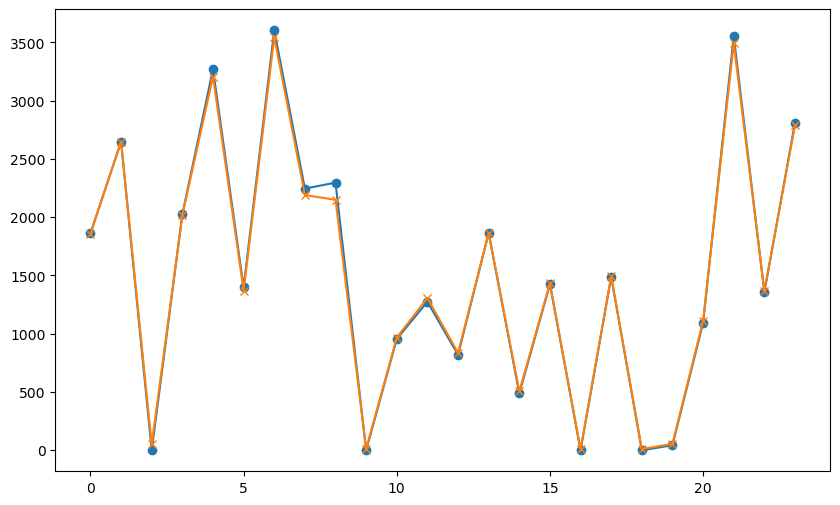

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:24], label='Actual (ANN)', marker='o')
plt.plot(y_pred_rescaled_ann[:24], label='Predicted (ANN)', marker='x')


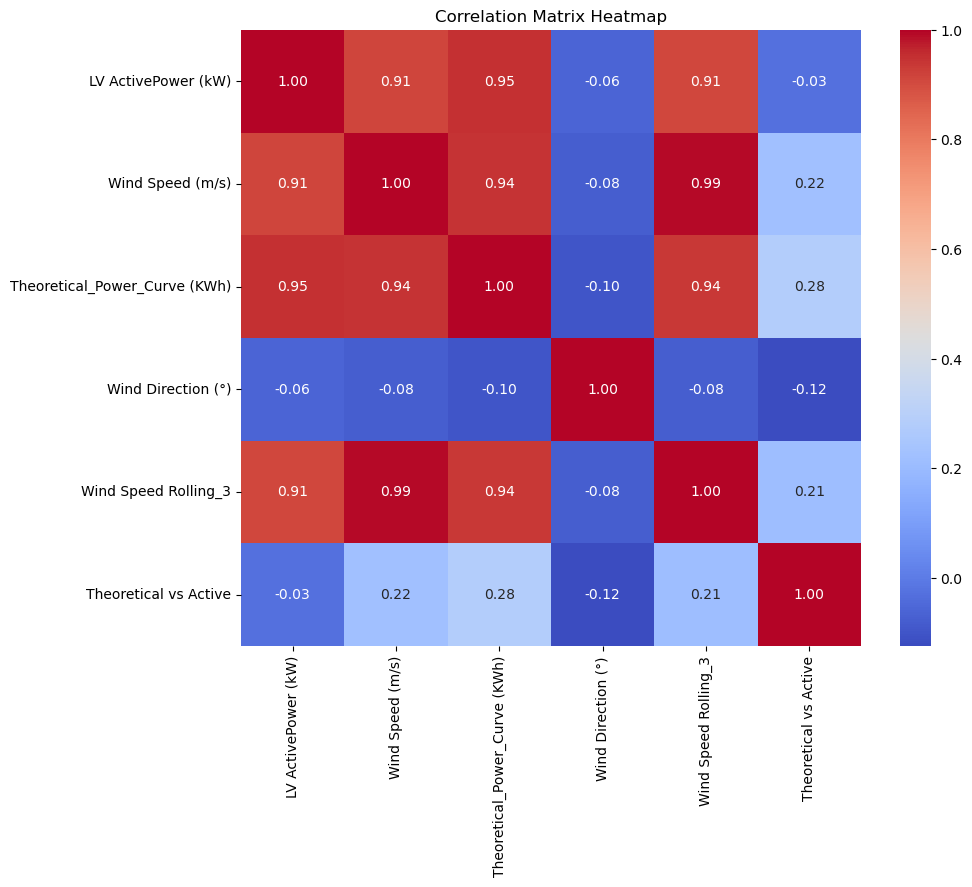

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

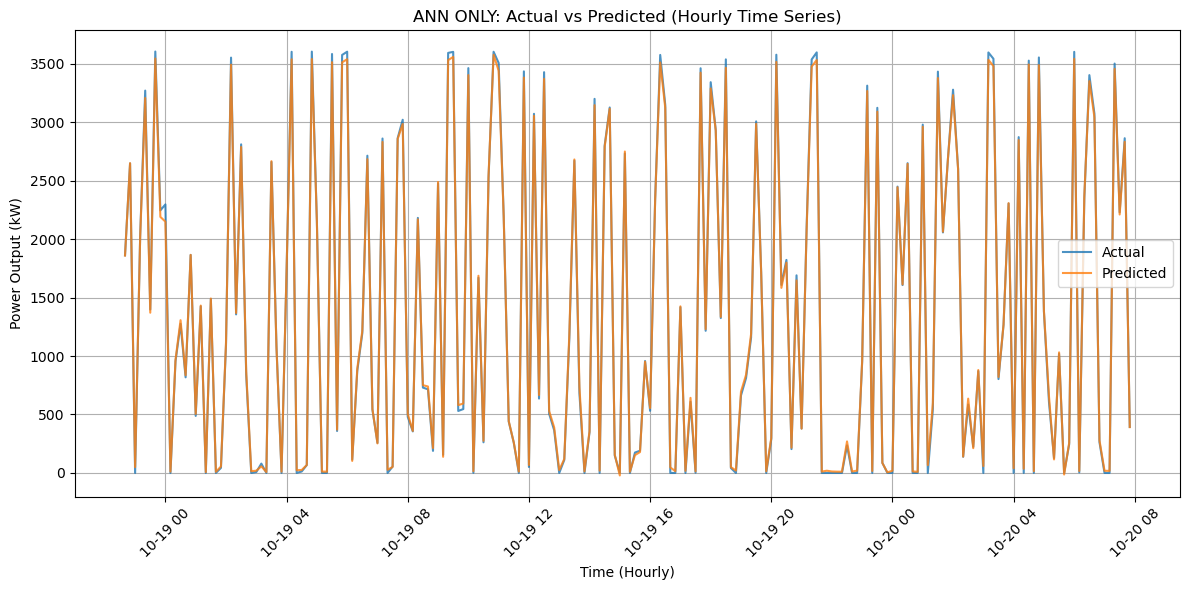

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_rescaled):][:200], y_test_rescaled[:200], label="Actual", alpha=0.8)
plt.plot(df.index[-len(y_pred_rescaled):][:200], y_pred_rescaled[:200], label="Predicted", alpha=0.8)
plt.title("ANN ONLY: Actual vs Predicted (Hourly Time Series)")
plt.xlabel("Time (Hourly)")
plt.ylabel("Power Output (kW)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [95]:
# Create a DataFrame with actual, predicted, and timestamps
results_df = pd.DataFrame({
    'Timestamp': df.index[-len(y_test_rescaled):],  # Use the datetime index for test data
    'Actual': y_test_rescaled.flatten(),           # Flatten the arrays for tabular display
    'Predicted': y_pred_rescaled.flatten()
})

# Display the first 200 rows
print(results_df.head(200))

# Save as CSV if needed
results_df.to_csv('predicted_vs_actual.csv', index=False)

              Timestamp       Actual    Predicted
0   2018-10-18 22:40:00  1861.003052  1859.149902
1   2018-10-18 22:50:00  2647.506104  2649.499756
2   2018-10-18 23:00:00     0.000000    50.111897
3   2018-10-18 23:10:00  2024.827026  2016.398438
4   2018-10-18 23:20:00  3269.898926  3206.825439
..                  ...          ...          ...
195 2018-10-20 07:10:00     0.000000    17.792574
196 2018-10-20 07:20:00  3501.027100  3456.191895
197 2018-10-20 07:30:00  2229.017090  2210.329346
198 2018-10-20 07:40:00  2862.638916  2831.885498
199 2018-10-20 07:50:00   393.289093   392.059357

[200 rows x 3 columns]
